In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# import tensor flow library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
tf.random.set_seed(42)

# import modules to graph ANN
import pydot
import pydotplus
import graphviz
import math
import scipy.stats



TFP Version 0.8.0
TF  Version 2.1.0


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 0.001-0.002


# Import Data

In [715]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 001-002.csv')

# Prepare Data

In [716]:
Data_final = np.array(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.2, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

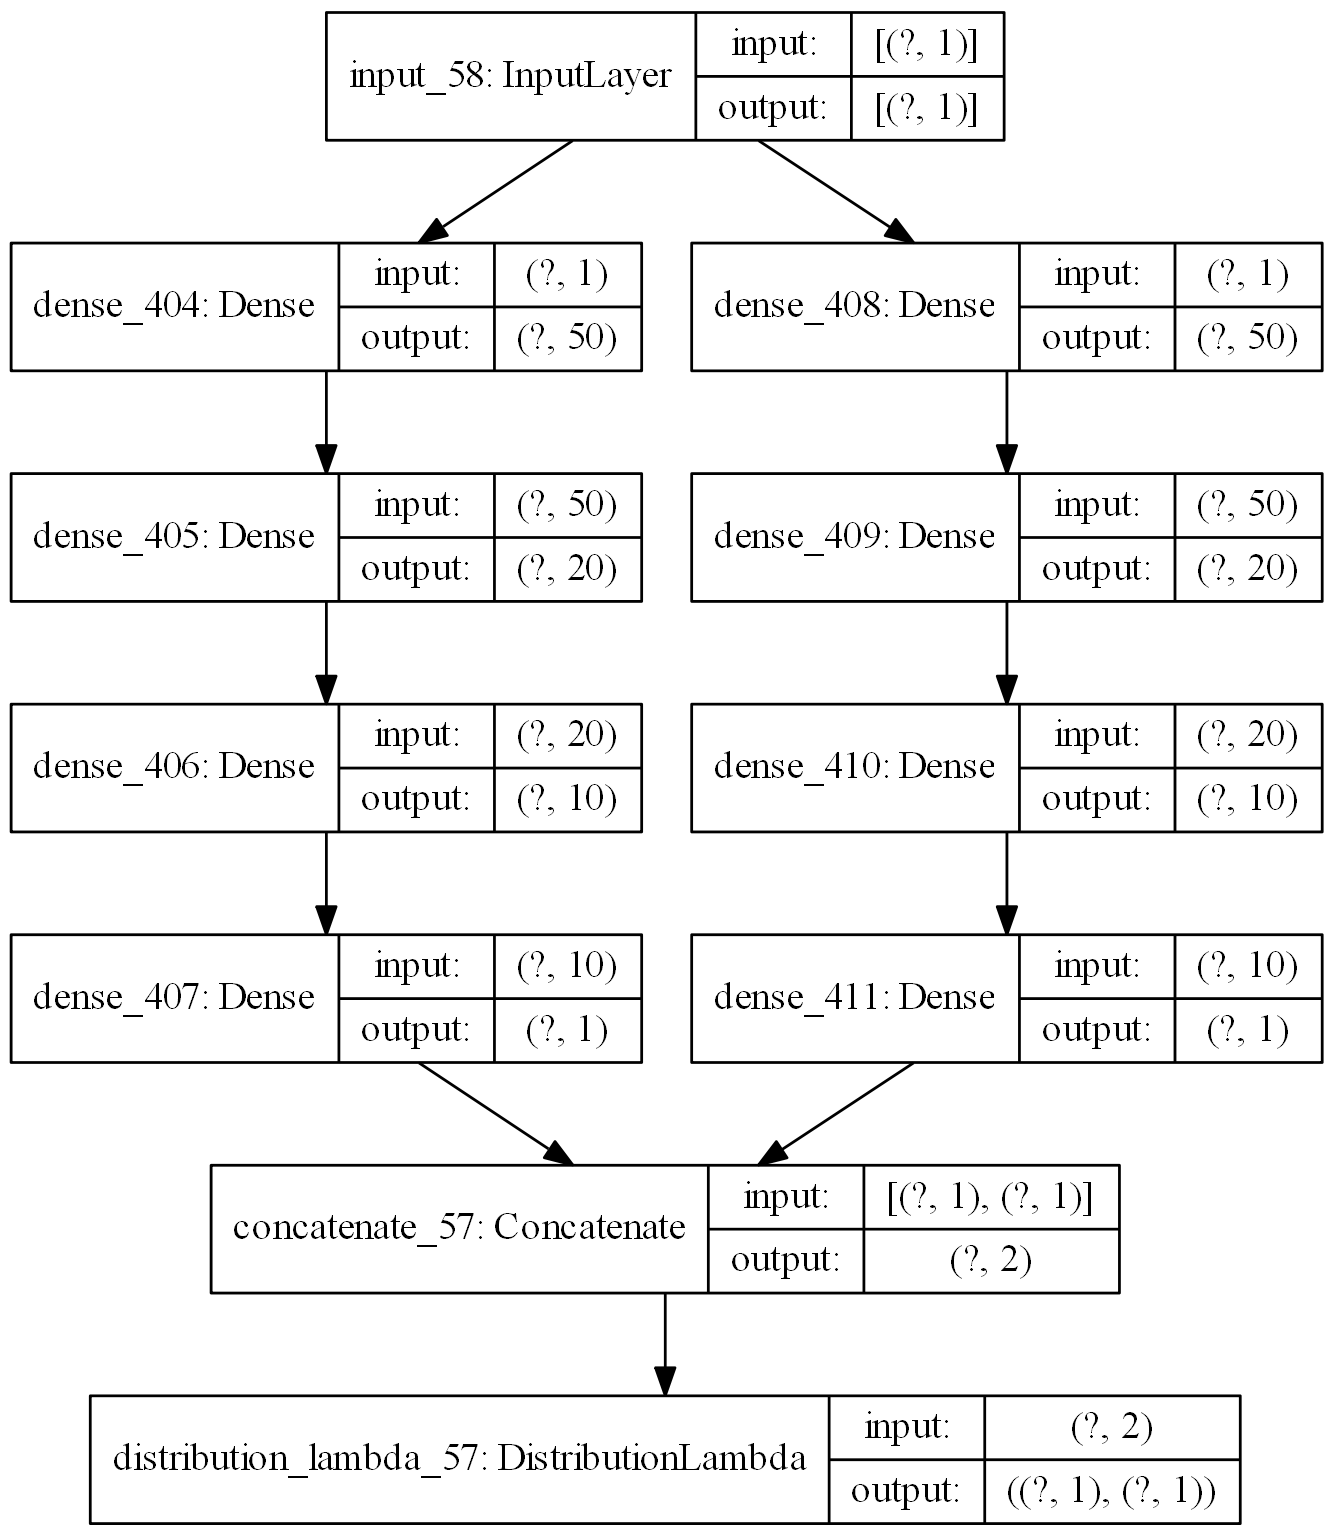

In [717]:

# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25 + tf.math.softplus(0.05 * params[:,1:2]) )


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR001 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR001.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR001, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)


# Training model

In [718]:
history1 = modelPnnPipeworkSR001.fit(train_data, train_traget, epochs=5000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Plot real data against predicted data

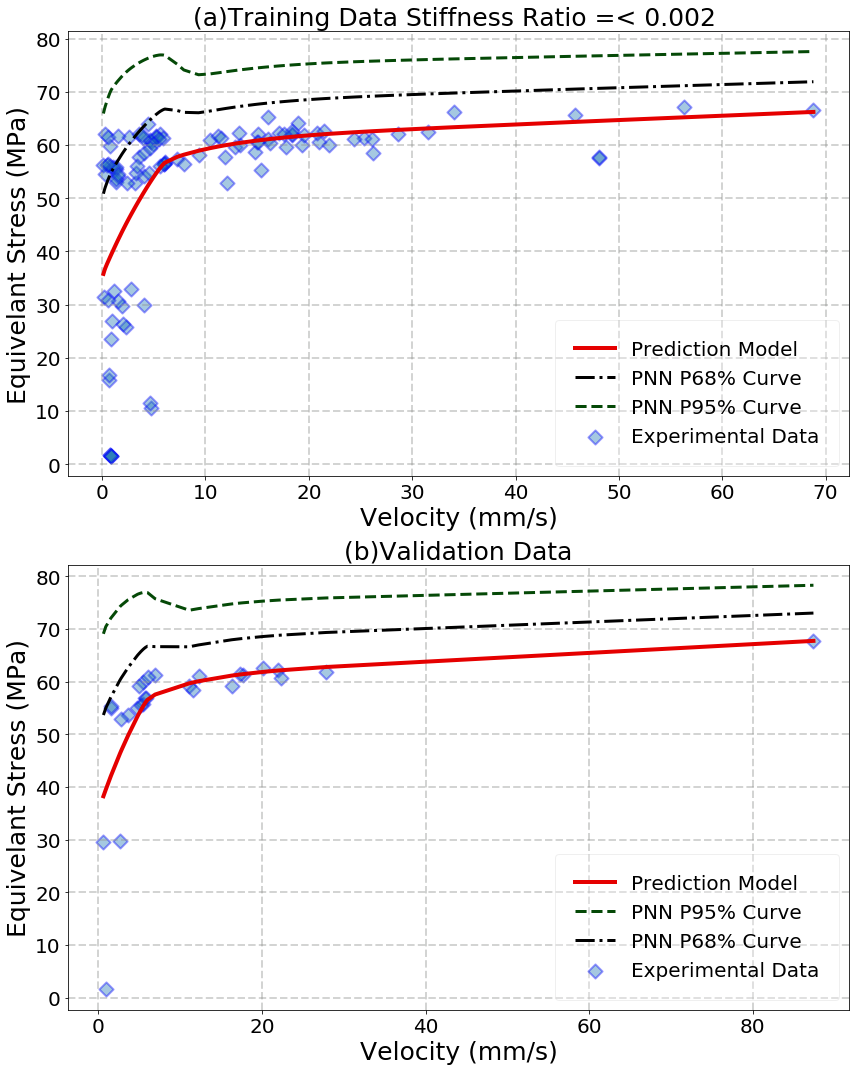

In [720]:
# Get model uncertainty
modelPnnPipeworkSR001_sd  = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR001.predict(train_data)
plt.scatter((train_set[:,0] ),
            (train_traget) ,
            alpha= 0.4,marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind] ),
         (preds[ind] ),
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSR001_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),
         color="Black",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSR001_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),
         color="#054907",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(a)Training Data Stiffness Ratio =< 0.002 " ,size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR001.predict(test_data)
plt.scatter((test_data) ,(test_traget) ,
            alpha= 0.4,marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]) ,
         (preds[ind]) ,
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model') 
preds_sd = preds+2* modelPnnPipeworkSR001_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="#054907",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSR001_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="Black",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)

plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [721]:
# Training data correaltion
# preds = modelPnnPipeworkSR001.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSR001.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ',val_corr)


Training Person correlation is   (0.7425972527692284, 9.188067999341839e-06)


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 0.002-0.1


# Import Data

In [712]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 01-02.csv')

# Prepare Data

In [713]:
Data_final = np.array(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.2, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

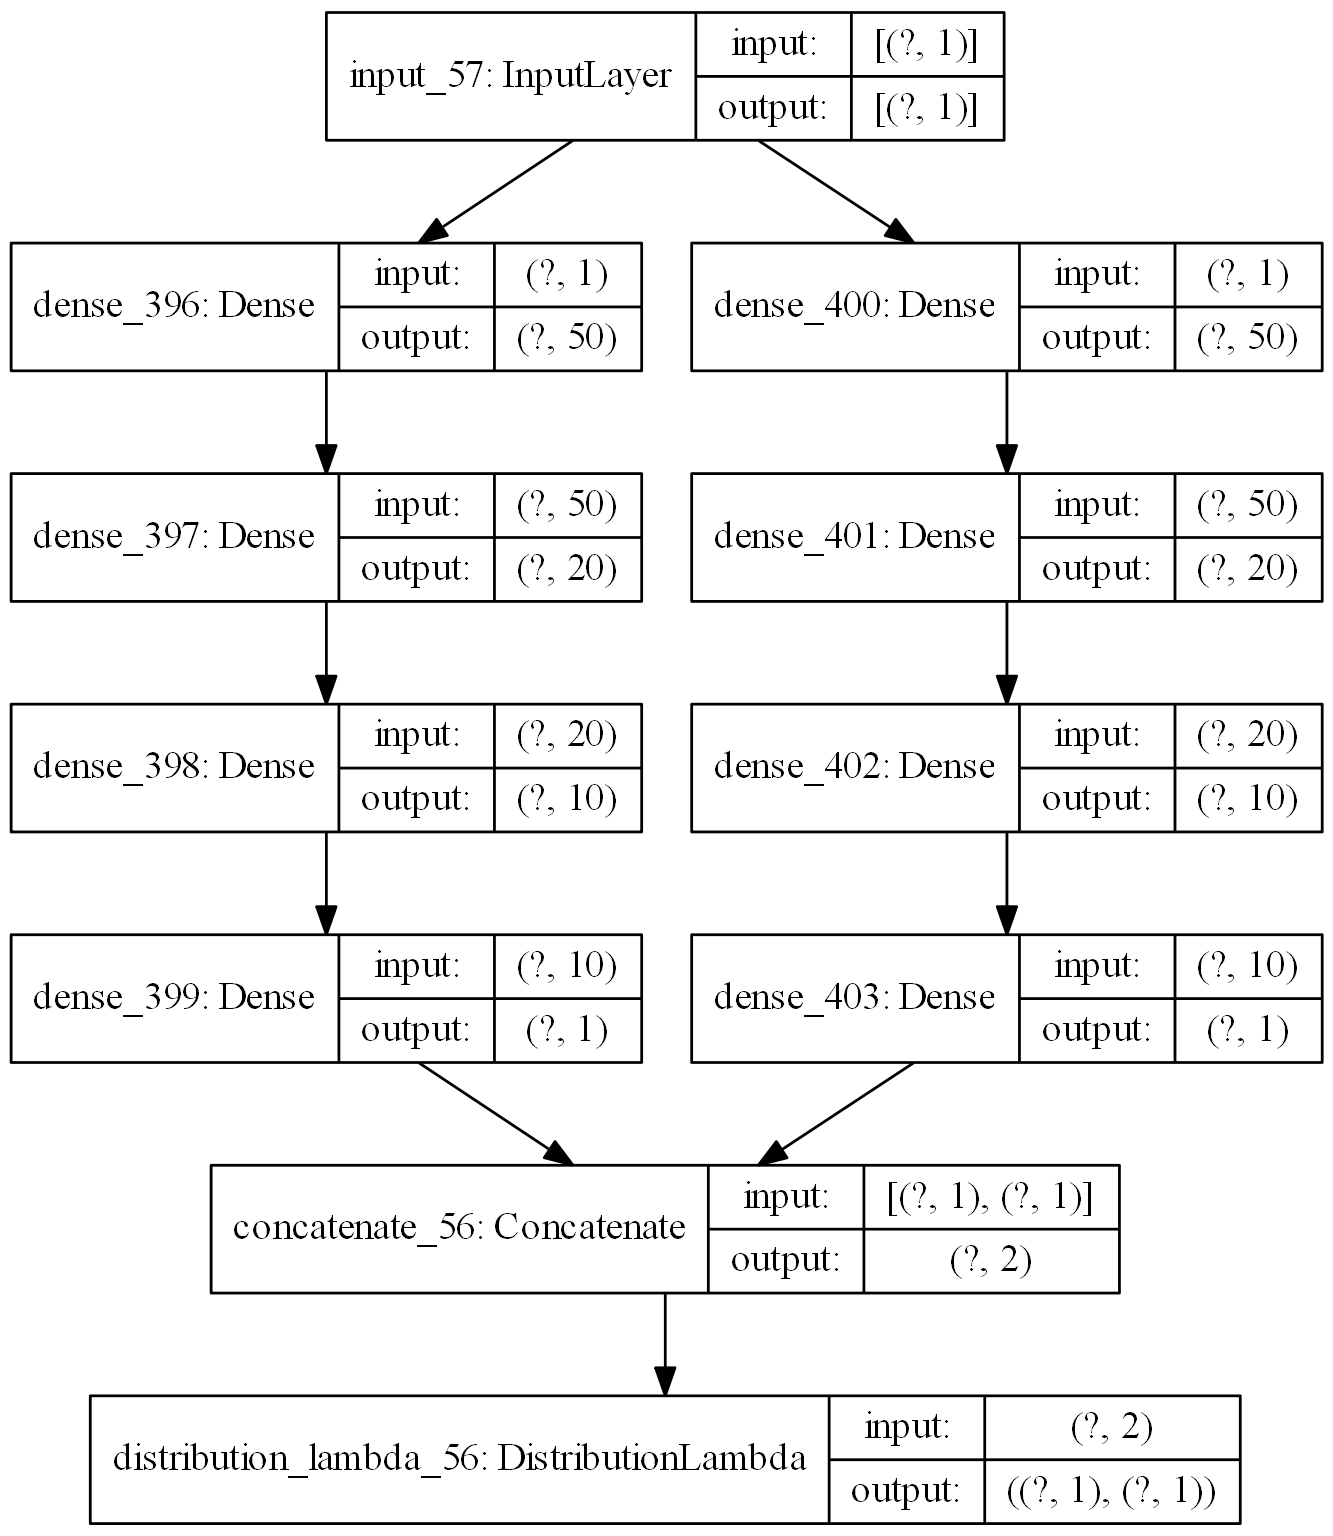

In [700]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.35 + tf.math.softplus(0.05 * params[:,1:2]) )


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR01.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR01, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [701]:
history2 = modelPnnPipeworkSR01.fit(train_data, train_traget, epochs=6000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Plot real data against predicted data

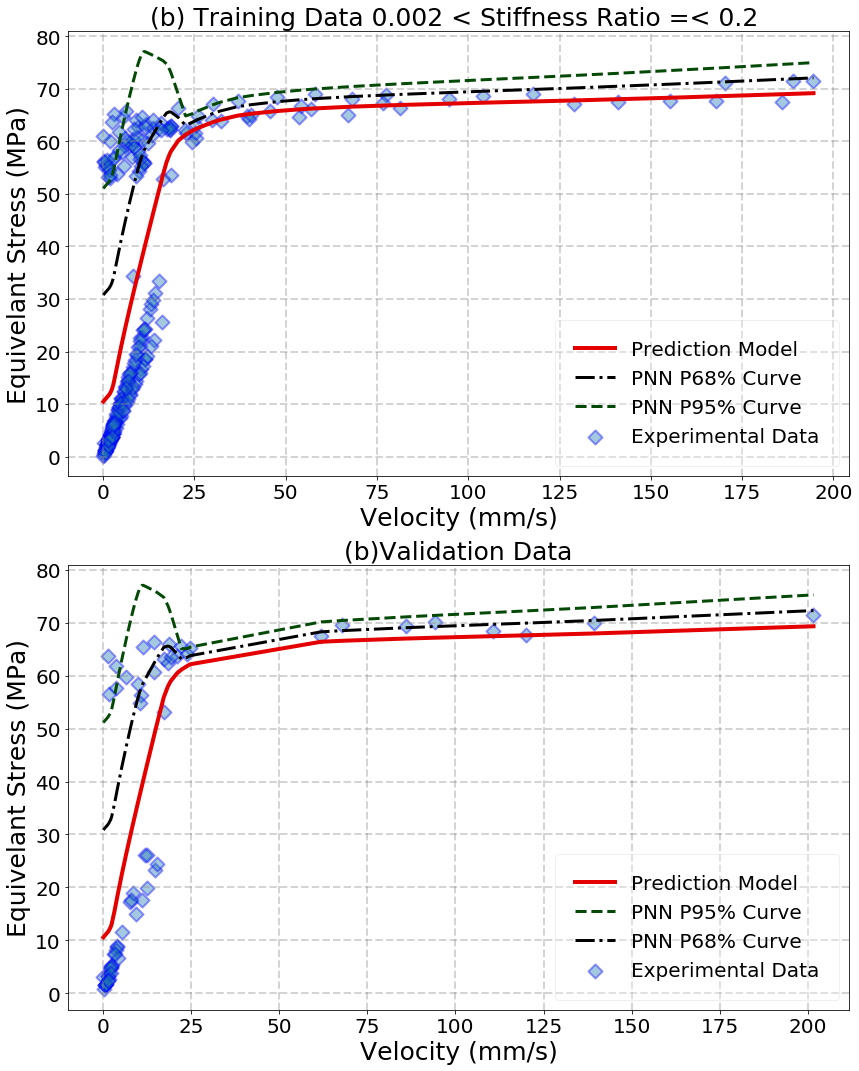

In [714]:
# Get model uncertainty
modelPnnPipeworkSR01_sd  = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR01.predict(train_data)
plt.scatter((train_set[:,0] ),
            (train_traget) ,
            alpha= 0.4,marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind] ),
         (preds[ind] ),
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),
         color="Black",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),
         color="#054907",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b) Training Data 0.002 < Stiffness Ratio =< 0.2 " ,size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR01.predict(test_data)
plt.scatter((test_data) ,(test_traget) ,
            alpha= 0.4,marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]) ,
         (preds[ind]) ,
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model') 
preds_sd = preds+2* modelPnnPipeworkSR01_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="#054907",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSR01_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="Black",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)

plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


In [704]:
# Training data correaltion
# preds =  modelPnnPipeworkSR01.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  modelPnnPipeworkSR01.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.8052603055126952, 1.047789340481858e-15)


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 5-20


# Import Data

In [707]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 5-20.csv')

# Prepare Data

In [708]:
Data_final = np.array(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.25, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

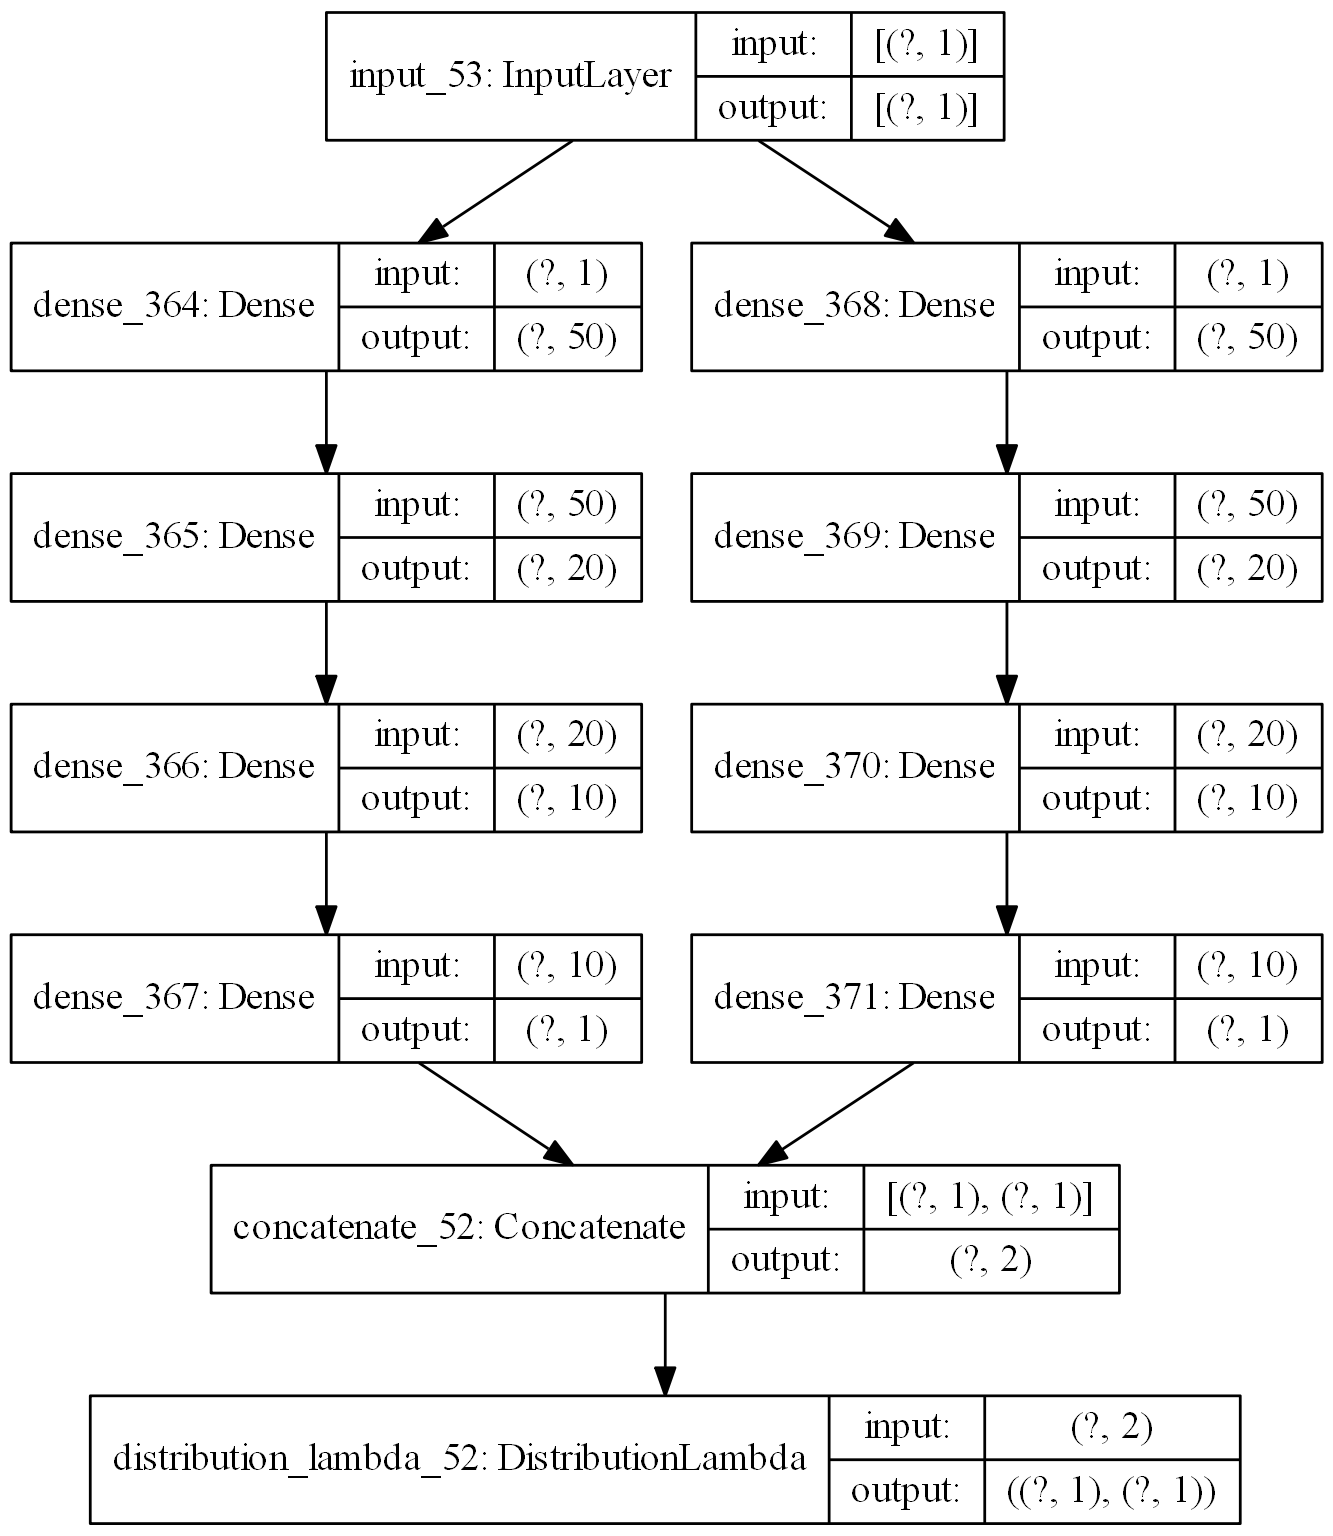

In [677]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25+ tf.math.softplus(0.05 * params[:,1:2]))


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR5 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR5.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR5, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [678]:
history3 = modelPnnPipeworkSR5.fit(train_data, train_traget, epochs=8000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Plot real data against predicted data

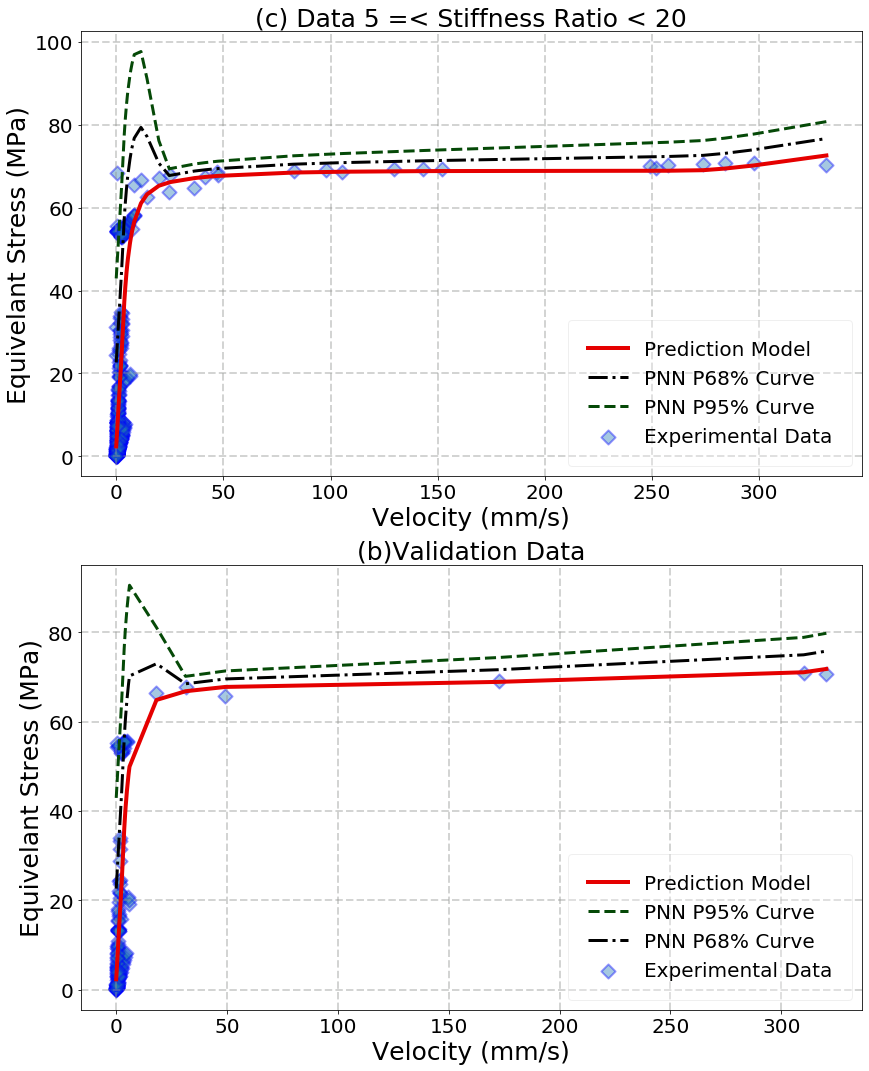

In [710]:
# Get model uncertainty
modelPnnPipeworkSR5_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR5.predict(train_data)
plt.scatter((train_set[:,0] ),
            (train_traget) ,
            alpha= 0.4,marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind] ),
         (preds[ind] ),
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSR5_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),
         color="Black",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSR5_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),
         color="#054907",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(c) Data 5 =< Stiffness Ratio < 20" ,size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR5.predict(test_data)
plt.scatter((test_data) ,(test_traget) ,
            alpha= 0.4,marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]) ,
         (preds[ind]) ,
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model') 
preds_sd = preds+2* modelPnnPipeworkSR5_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="#054907",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSR5_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="Black",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)

plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()



# Calculate correaltion factor for training and validation data

In [ ]:
# Training data correaltion
preds = modelPnnPipeworkSR5.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## All Data 


# Import Data

In [112]:
# get data from csv file
Data = pd.read_csv('Pipework data SR All.csv')

# Prepare Data

In [9]:
Data_final = np.array(Data)
# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.25, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

In [10]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1+ tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the PNN
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSRAll = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSRAll.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSRAll, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# Training model

In [11]:
history3 = modelPnnPipeworkSRAll.fit(train_data, train_traget, epochs=8000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

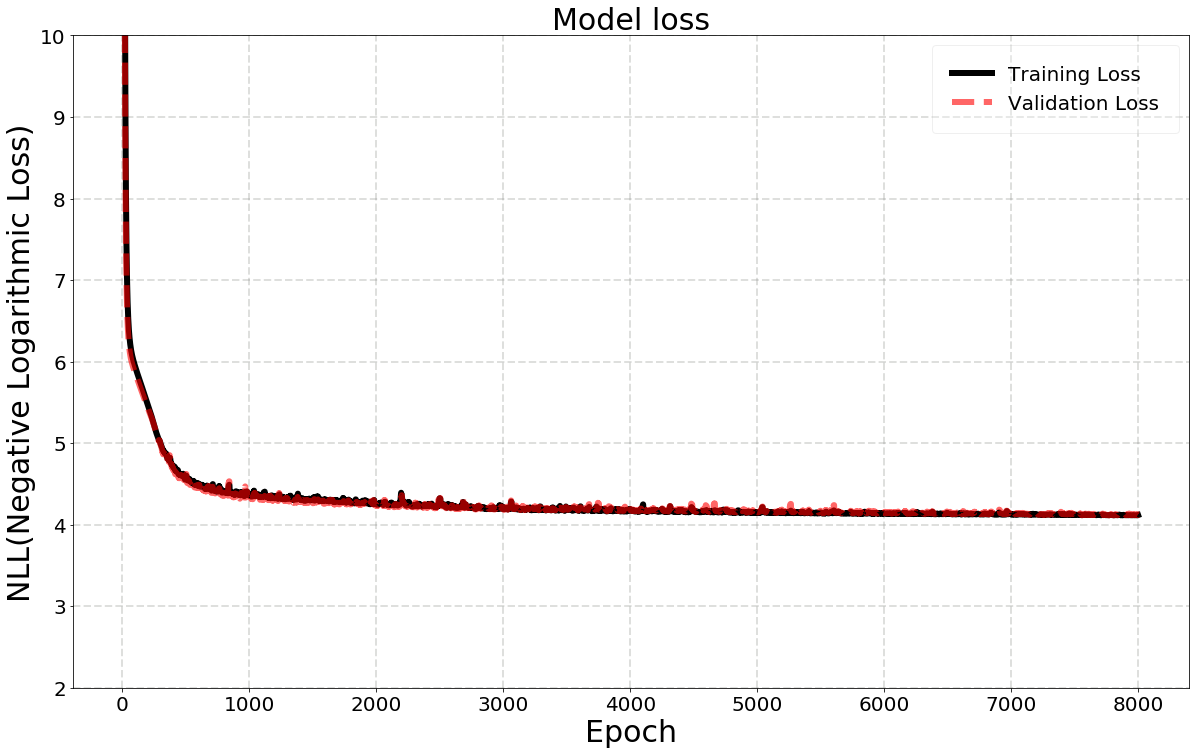

In [12]:
# Plot Model Loss
modelPnnPipeworkSRAll = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history3.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,12))
# plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
# plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=6,color = 'black', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=6,color = 'red',alpha =0.6, linestyle='--', label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(2,10)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

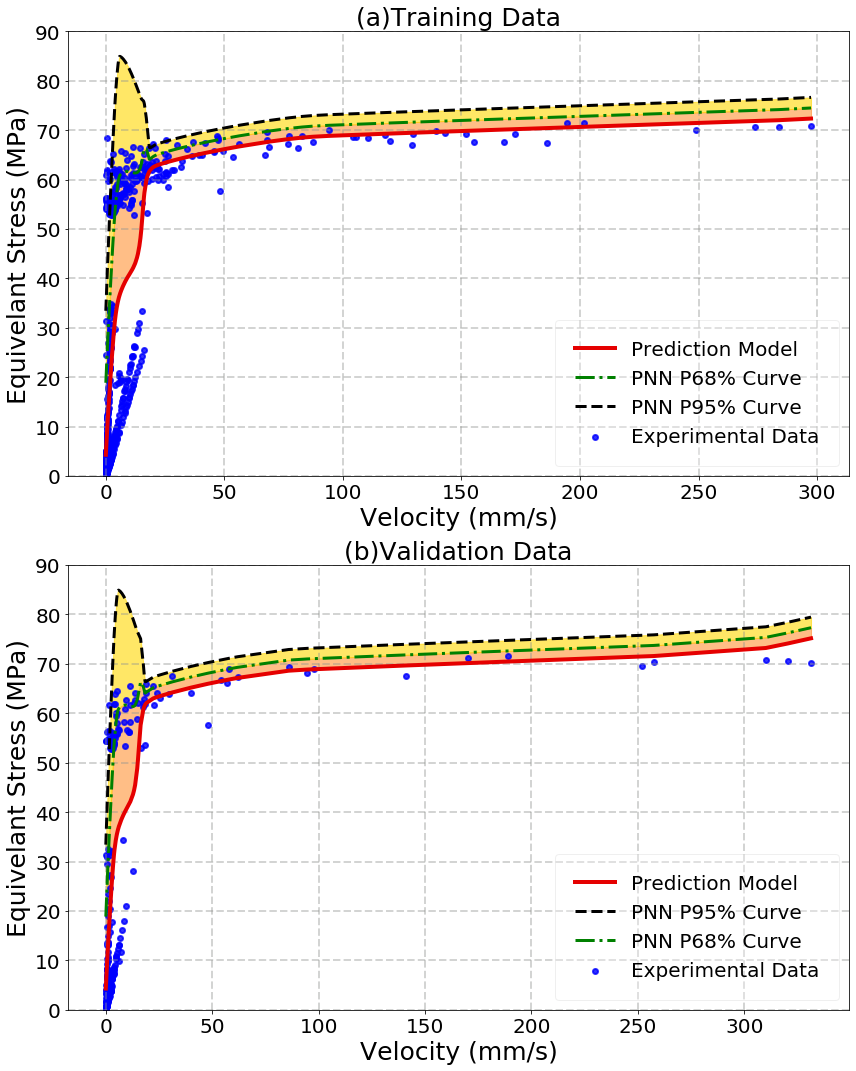

In [110]:
# Get model uncertainty
modelPnnPipeworkSRAll_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)



preds = modelPnnPipeworkSRAll.predict(train_data)
ind = np.argsort (train_data,axis = 0)
preds_sd = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.fill_between(train_set[:,0][ind],preds[ind].reshape((-1,)),preds_sd[ind].reshape((-1,)),color='C1', alpha=0.5)

preds_sd1 = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(train_data))
preds_sd = (preds+ 2* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.fill_between(train_set[:,0][ind],preds_sd1[ind].reshape((-1,)),preds_sd[ind].reshape((-1,)),color = '#FFD700',alpha=0.6)

plt.scatter((train_set[:,0]),(train_traget), color="blue",
            alpha= 0.8,marker='.',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')

ind = np.argsort (train_data,axis = 0)
plt.plot(train_set[:,0][ind],preds[ind],
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model')

preds_sd = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.plot(train_set[:,0][ind],preds_sd[ind],
         color="#008000",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.plot((train_set[:,0][ind]),(preds_sd[ind]),
         color="Black",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')





plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim([0,90])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)


# Subplot2 validation data
plt.subplot(2,1,2)


preds = modelPnnPipeworkSRAll.predict(test_data)
ind = np.argsort (test_data,axis = 0)
preds_sd = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(test_data))
plt.fill_between(test_data[ind],preds[ind].reshape((-1,)),preds_sd[ind].reshape((-1,)),color='C1', alpha=0.5)

preds_sd1 = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(test_data))
preds_sd = (preds+ 2* modelPnnPipeworkSRAll_sd.predict(test_data))
plt.fill_between(test_data[ind],preds_sd1[ind].reshape((-1,)),preds_sd[ind].reshape((-1,)),color = '#FFD700',alpha=0.6)



preds = modelPnnPipeworkSRAll.predict(test_data)
plt.scatter((test_data),(test_traget), color="blue",
            alpha= 0.8,marker='.',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]),(preds[ind]),
         color="#E50000", linestyle='-',linewidth=4,  label = 'Prediction Model') 

preds_sd = preds+2* modelPnnPipeworkSRAll_sd.predict(test_data)
plt.plot((test_data[ind]),(preds_sd[ind]),
         color="Black",linestyle='--',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSRAll_sd.predict(test_data)
plt.plot((test_data[ind]),(preds_sd[ind]),
         color="#008000",linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')
plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim([0,90])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [14]:
# Training data correaltion
preds = modelPnnPipeworkSRAll.predict(train_data)
train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSRAll.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.7447237705072413, 1.1311695139840224e-136)
Training Person correlation is   (0.7633916586443503, 4.0110112018854616e-50)


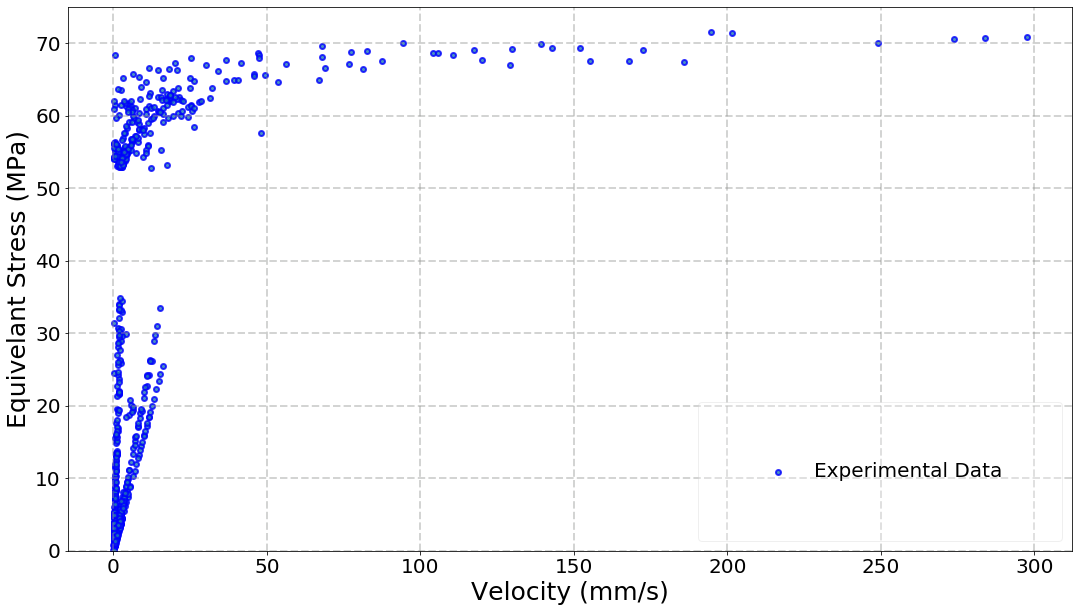

In [111]:

# Create figure
plt.figure(figsize=(18,10))


plt.scatter((train_set[:,0]),(train_traget), 
            alpha= 0.8,marker='.',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')


plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim([0,75])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=3)


# Plot real data vs predicted data

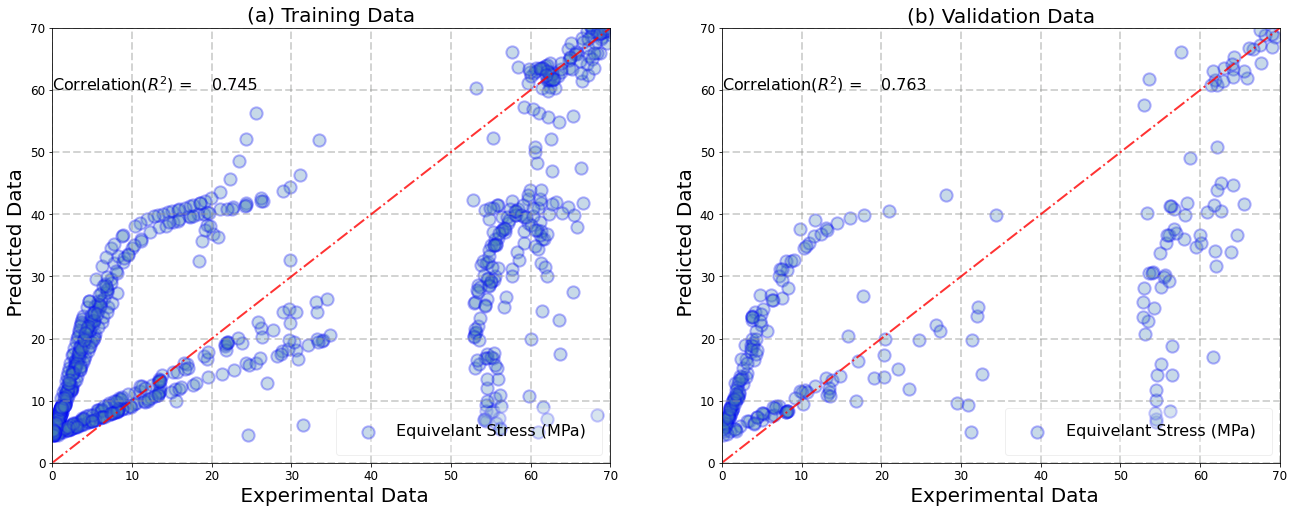

In [51]:
# Create figure
plt.figure(figsize=(22,8))

# Subplot1 training data
plt.subplot(1,2,1)
preds = modelPnnPipeworkSRAll.predict(train_data)
plt.plot((train_traget[np.argsort (train_traget,axis = 0)]),
         (train_traget[np.argsort (train_traget,axis = 0)]),
         color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(train_traget,preds,
            color="steelblue",edgecolors="#0000FF",
            s =150,alpha = 0.3,linewidth=2, label = "Equivelant Stress (MPa)") 
plt.xlabel(( ' Experimental Data'),size=20)
plt.ylabel(( ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1,loc=4)

plt.title("(a) Training Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.text(0, 60, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(20, 60, round (train_corr[0],3) , fontsize = 16)
plt.xlim([0,70])
plt.ylim([0,70])

# subplot2 validation data
plt.subplot(1,2,2)
preds = modelPnnPipeworkSRAll.predict(test_data)
plt.plot((test_traget[np.argsort (test_traget,axis = 0)]),
         (test_traget[np.argsort (test_traget,axis = 0)]),
         color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(test_traget,
            preds ,color="steelblue",edgecolors="#0000FF",
            s =150,alpha = 0.3,linewidth=2, label = "Equivelant Stress (MPa)") 

plt.xlabel(( ' Experimental Data'),size=20)
plt.ylabel(( ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1,loc=4)
plt.title("(b) Validation Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.text(0, 60, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(20, 60, round (val_corr[0],3) , fontsize = 16)
plt.xlim([0,70])
plt.ylim([0,70])
plt.show()

# PNN network with Non Constant variant and Beam Fatigue data

## Import and Prepare Data

In [600]:
Data = pd.read_csv('Default Dataset.csv')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data_final = scaler.fit_transform(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.2, random_state=42)
train_data = train_set[:,1]
train_traget = train_set[:,0]
test_data = test_set[:,1]
test_traget =  test_set[:,0]


## Print Original Data

(array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 <a list of 9 Text yticklabel objects>)

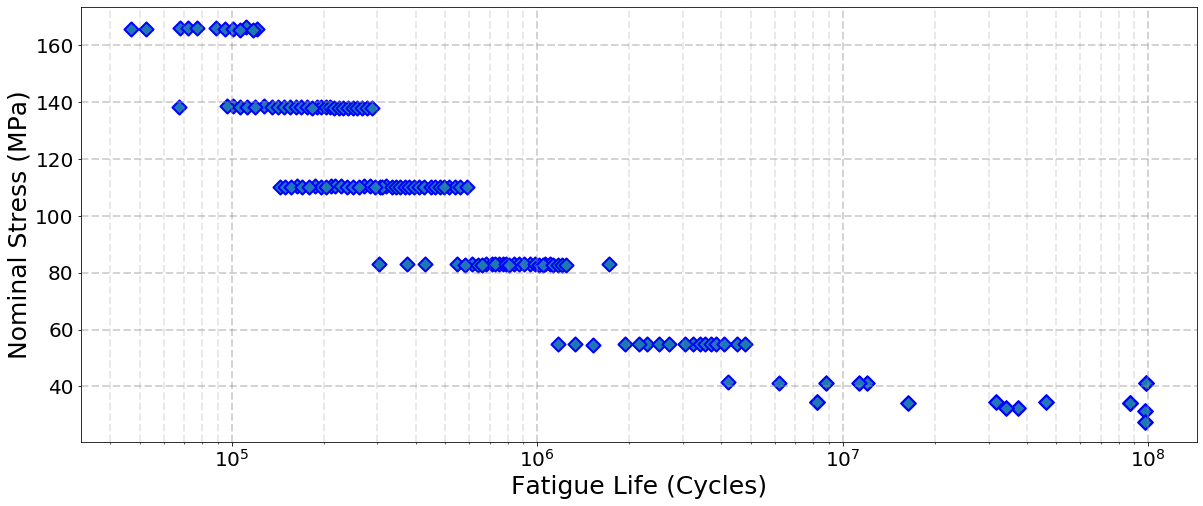

In [619]:
# Create figure
plt.figure(figsize=(20,8))


preds = modelPnnPipeworkSR01.predict(train_data)

plt.scatter((Data_final[:,0]*(scaler.var_[0]**0.5))+scaler.mean_[0],(Data_final[:,1] *(scaler.var_[1]**0.5))+scaler.mean_[1],
            marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')


plt.xscale('log')
plt.ylabel("Nominal Stress (MPa)",size=25)
plt.xlabel("Fatigue Life (Cycles)",size=25)
#plt.title("Experimental Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
#plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)

# Create PNN

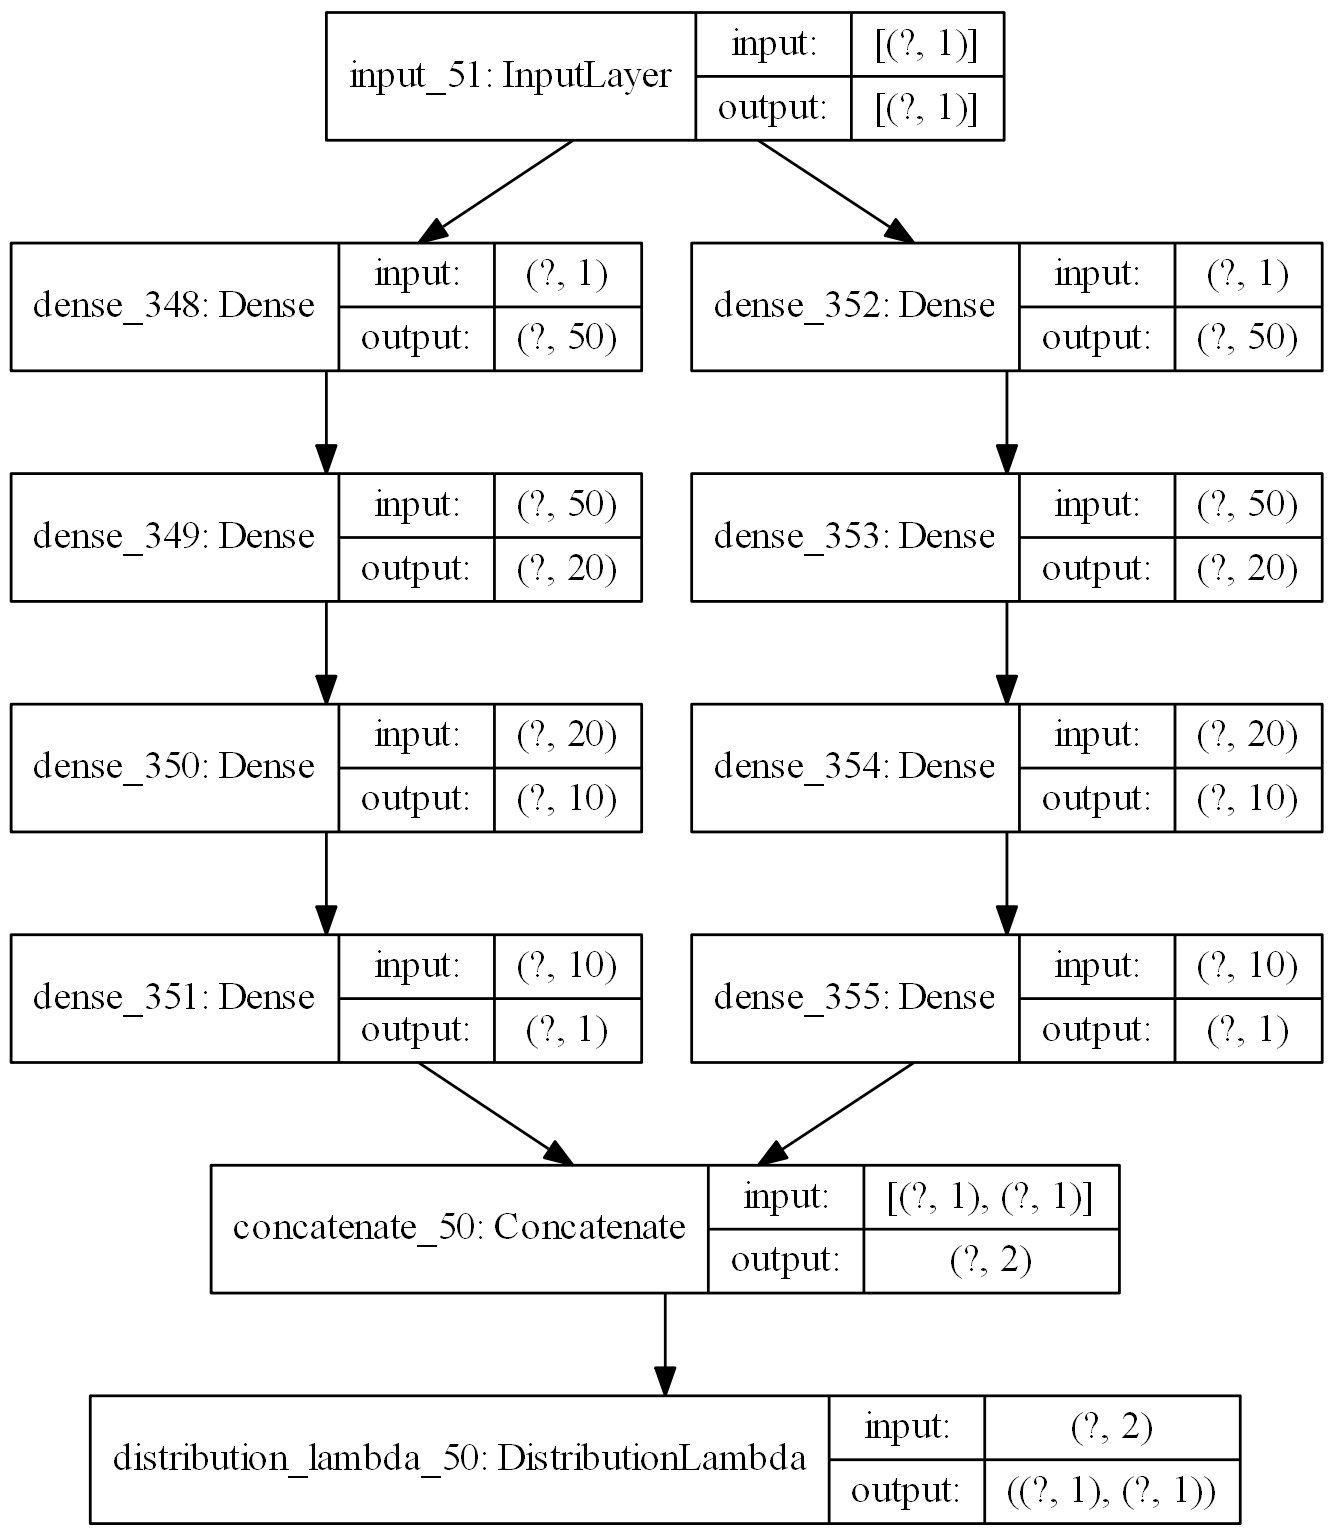

In [625]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.00001 + tf.math.softplus(0.05 * params[:,1:2]) )


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR01.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR01, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [626]:
history2 = modelPnnPipeworkSR01.fit(train_data, train_traget, epochs=120000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

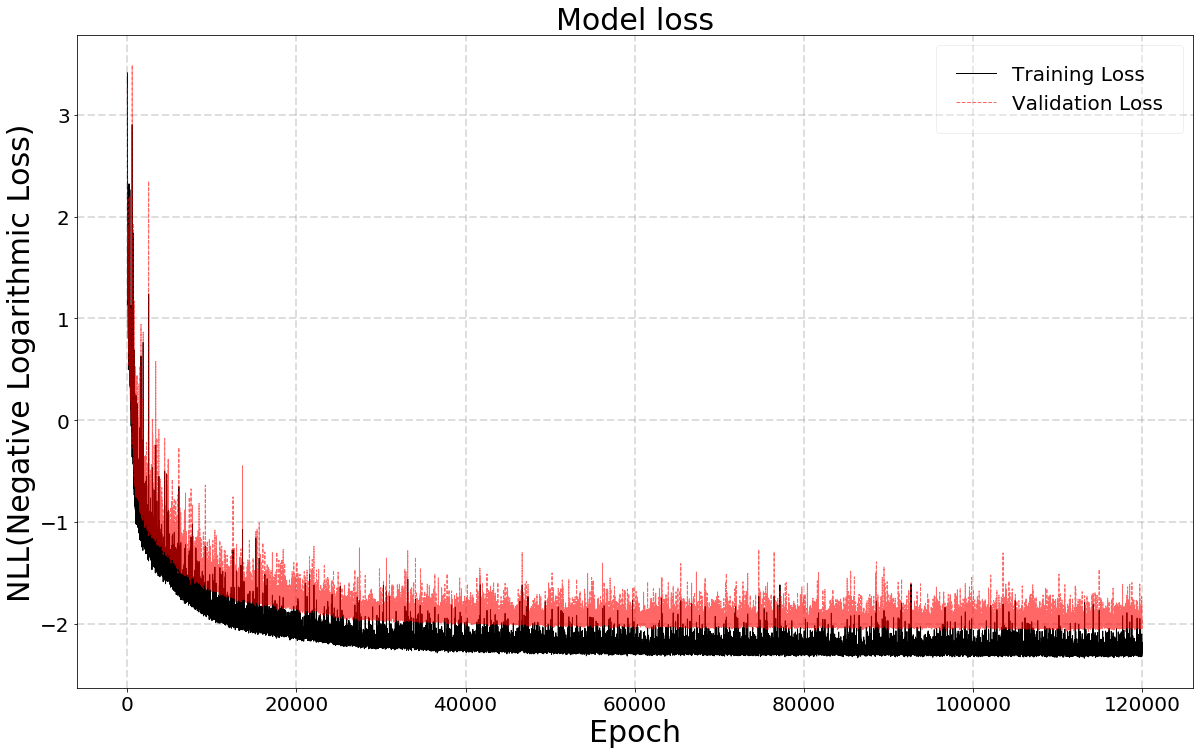

In [633]:
# Plot Model Loss
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history2.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,12))
# plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
# plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=1,color = 'black', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=1,color = 'red',alpha =0.6, linestyle='--', label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
#plt.gca().set_ylim(-3,10)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

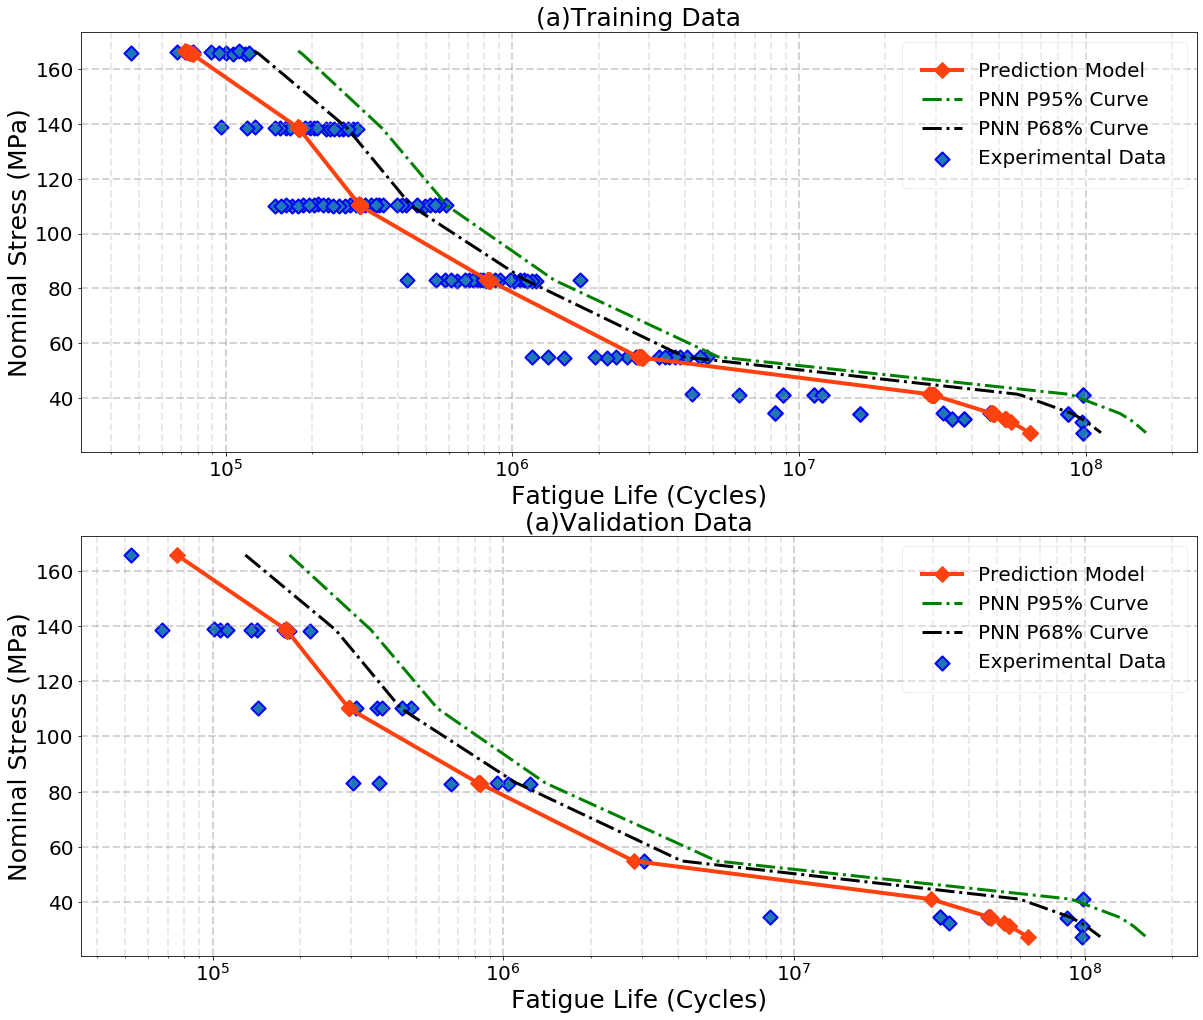

In [628]:
# Create figure
plt.figure(figsize=(20,17))

# Subplot1 training data
plt.subplot(2,1,1)


preds = modelPnnPipeworkSR01.predict(train_data)

plt.scatter((train_traget*(scaler.var_[0]**0.5))+scaler.mean_[0],(train_data *(scaler.var_[1]**0.5))+scaler.mean_[1],
            marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')

ind = np.argsort (preds,axis = 0)
plt.plot((preds[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0] ,(train_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1],
         color="#FE420F", linestyle='-',linewidth=4, marker='D',markersize=12, label = 'Prediction Model')
# # Get model uncertainty
modelPnnPipeworkSR01_sd = Model(inputs=inputs, outputs=dist.stddev())
preds_sd = (preds+ 2* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(train_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="#008000",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

preds_sd = (preds+1* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(train_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="Black",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')



plt.xscale('log')
plt.ylabel("Nominal Stress (MPa)",size=25)
plt.xlabel("Fatigue Life (Cycles)",size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)




# Subplot2 validation data
plt.subplot(2,1,2)

preds = modelPnnPipeworkSR01.predict(test_data)

plt.scatter((test_traget*(scaler.var_[0]**0.5))+scaler.mean_[0],(test_data *(scaler.var_[1]**0.5))+scaler.mean_[1],
            marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')

ind = np.argsort (preds,axis = 0)
plt.plot((preds[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0] ,(test_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1],
         color="#FE420F", linestyle='-',linewidth=4, marker='D',markersize=12, label = 'Prediction Model')
# # Get model uncertainty
modelPnnPipeworkSR01_sd = Model(inputs=inputs, outputs=dist.stddev())
preds_sd = (preds+ 2* modelPnnPipeworkSR01_sd.predict(test_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(test_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="#008000",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

preds_sd = (preds+1* modelPnnPipeworkSR01_sd.predict(test_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(test_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="Black",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')

plt.xscale('log')
plt.ylabel("Nominal Stress (MPa)",size=25)
plt.xlabel("Fatigue Life (Cycles)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



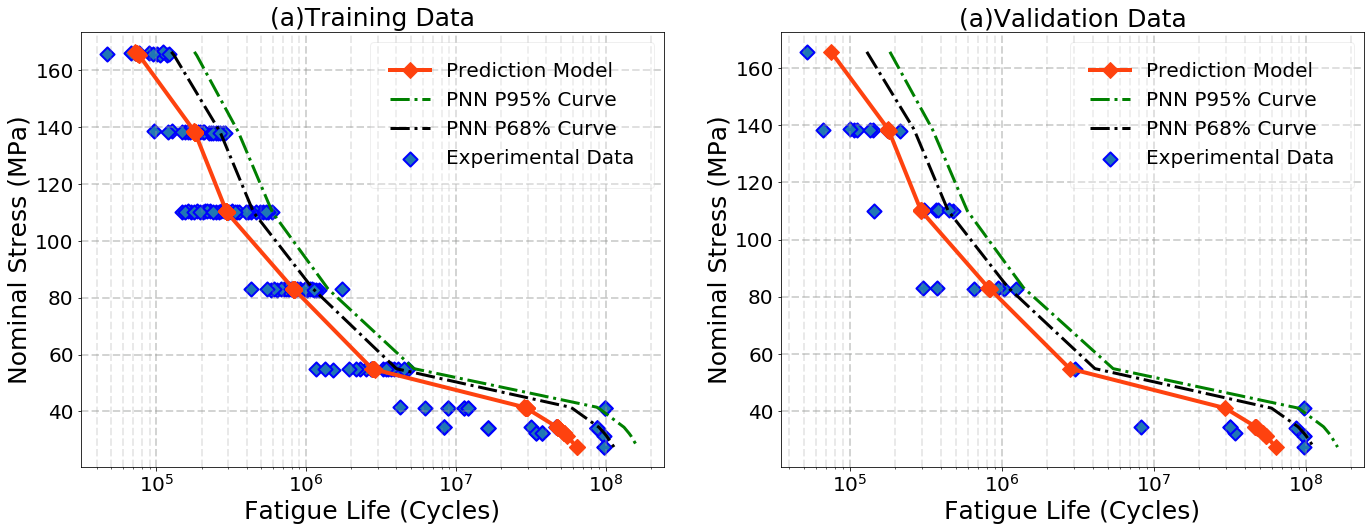

In [629]:
# Create figure
plt.figure(figsize=(23,8))

# Subplot1 training data
plt.subplot(1,2,1)


preds = modelPnnPipeworkSR01.predict(train_data)

plt.scatter((train_traget*(scaler.var_[0]**0.5))+scaler.mean_[0],(train_data *(scaler.var_[1]**0.5))+scaler.mean_[1],
            marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')

ind = np.argsort (preds,axis = 0)
plt.plot((preds[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0] ,(train_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1],
         color="#FE420F", linestyle='-',linewidth=4, marker='D',markersize=12, label = 'Prediction Model')
# # Get model uncertainty
modelPnnPipeworkSR01_sd = Model(inputs=inputs, outputs=dist.stddev())
preds_sd = (preds+ 2* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(train_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="#008000",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

preds_sd = (preds+1* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(train_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="Black",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')



plt.xscale('log')
plt.ylabel("Nominal Stress (MPa)",size=25)
plt.xlabel("Fatigue Life (Cycles)",size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)




# Subplot2 validation data
plt.subplot(1,2,2)

preds = modelPnnPipeworkSR01.predict(test_data)

plt.scatter((test_traget*(scaler.var_[0]**0.5))+scaler.mean_[0],(test_data *(scaler.var_[1]**0.5))+scaler.mean_[1],
            marker='D',s=100,linewidth=2,edgecolors="blue",label = 'Experimental Data')

ind = np.argsort (preds,axis = 0)
plt.plot((preds[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0] ,(test_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1],
         color="#FE420F", linestyle='-',linewidth=4, marker='D',markersize=12, label = 'Prediction Model')
# # Get model uncertainty
modelPnnPipeworkSR01_sd = Model(inputs=inputs, outputs=dist.stddev())
preds_sd = (preds+ 2* modelPnnPipeworkSR01_sd.predict(test_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(test_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="#008000",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P95% Curve')

preds_sd = (preds+1* modelPnnPipeworkSR01_sd.predict(test_data))
plt.plot((preds_sd[ind].reshape([-1,1])*(scaler.var_[0]**0.5))+scaler.mean_[0],(test_data[ind].reshape([-1,1])*(scaler.var_[1]**0.5))+scaler.mean_[1], color="Black",
          linestyle='-.',alpha  = 1,linewidth=3,label = 'PNN P68% Curve')

plt.xscale('log')
plt.ylabel("Nominal Stress (MPa)",size=25)
plt.xlabel("Fatigue Life (Cycles)",size=25)
plt.title("(a)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)

In [630]:
# Training data correaltion
preds =  modelPnnPipeworkSR01.predict(train_data)
train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  modelPnnPipeworkSR01.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('test Person correlation is  ', val_corr)

Training Person correlation is   (0.7551664620723344, 1.3211266240152067e-25)
test Person correlation is   (0.8362381373304657, 1.3681334922149334e-09)


# Simulated Data Sample

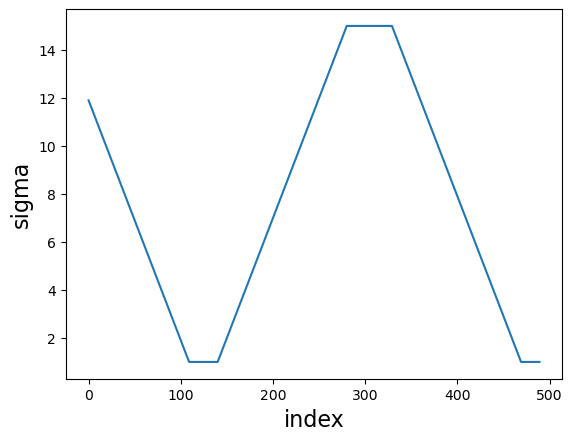

In [4]:
# Generate data envelope
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()


In [5]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

In [6]:
# generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [7]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

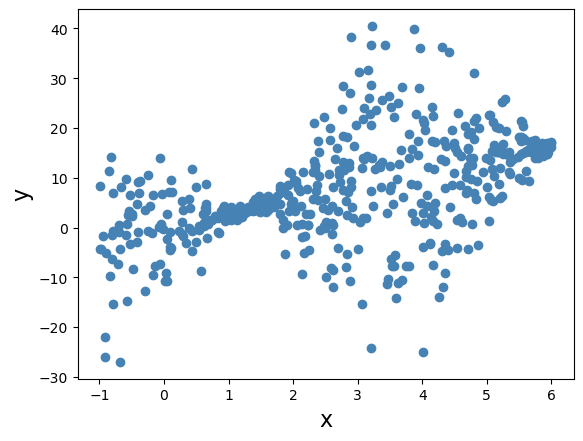

In [8]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

In [11]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


# Train Constant Variance Network

In [31]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params, scale=8)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)

dist = tfp.layers.DistributionLambda(my_dist)(params) 
model_sd_5 = Model(inputs=inputs, outputs=dist)
model_sd_5.compile(Adam(), loss=NLL) 

model_sd_5.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model_sd_5.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

In [33]:
model_mean_sd_5 = Model(inputs=inputs, outputs=dist.mean())

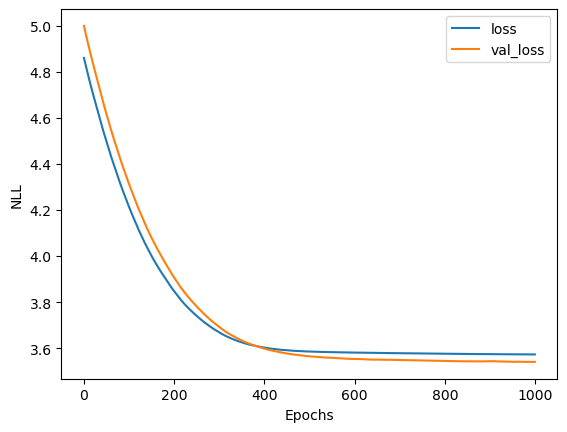

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

# Train Non-Constant Varaince Network

In [49]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs) 
hidden1 = Dense(30,activation="relu")(inputs)
hidden1 = Dense(20,activation="relu")(hidden1)
hidden2 = Dense(20,activation="relu")(hidden1)
out2 = Dense(1)(hidden2) 
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.01), loss=NLL)

In [50]:
model_flex_sd.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 30)           60          input_7[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 20)           620         dense_21[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 20)           420         dense_22[0][0]                   
___________________________________________________________________________________________

In [51]:
history = model_flex_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [52]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

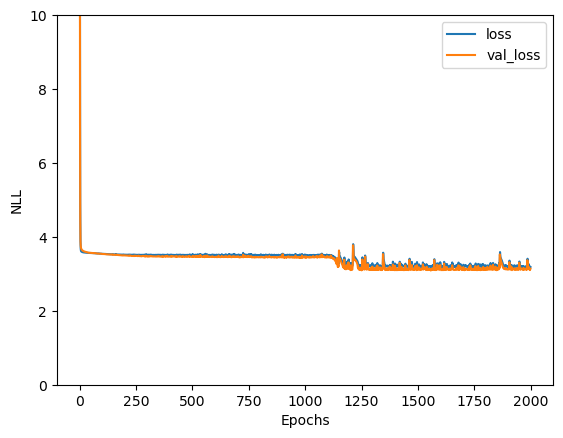

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim(0,10)
plt.show()

In [28]:
print(model_flex_sd.evaluate(x_train,y_train, verbose=0))
print(model_flex_sd.evaluate(x_val,y_val, verbose=0))

3.1819518157646516
3.140357861647735


(-30.0, 55.0)

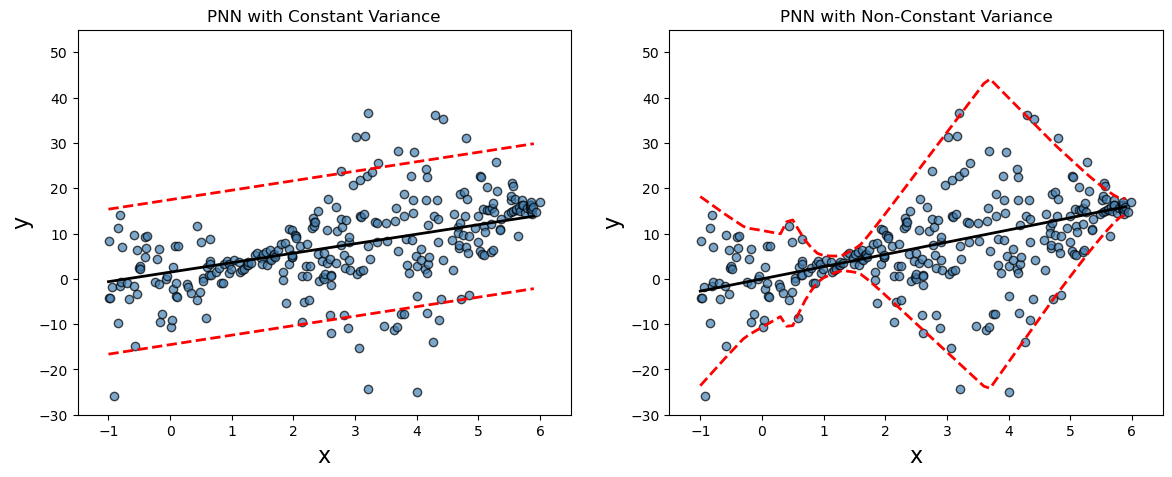

In [57]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)


plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue",alpha=0.7, edgecolors="k") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = 8
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("PNN with Constant Variance")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,2)
plt.scatter(x_train,y_train,color="steelblue",alpha=0.7, edgecolors="k") 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("PNN with Non-Constant Variance")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])